In [32]:
%run noninteractive_utilities
%run utilities

import numpy as np

verbose = True
num_districts = 9

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
dpi = 200
mpl.rcParams['figure.dpi']= dpi


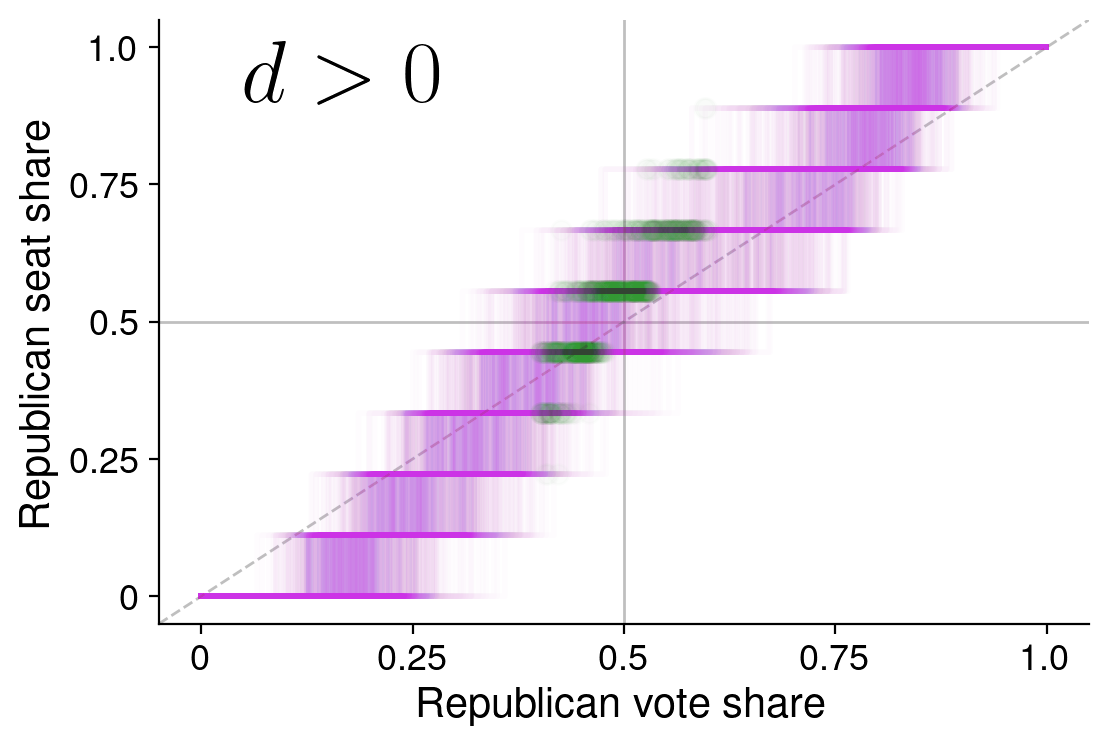

In [49]:
delta_threshold = 0
num_plans_to_get = 1000
min_republican_vote_share = 0.4
max_republican_vote_share = 0.6
bulk_votes = []
bulk_seats = []
actual_vote_shares = []
actual_seat_shares = []

while len(bulk_votes) < num_plans_to_get:
    vote_shares_by_district = np.random.uniform(0, 1, num_districts)
    
    if np.mean(vote_shares_by_district) >= min_republican_vote_share \
    and np.mean(vote_shares_by_district) < max_republican_vote_share:
        republican_winners = vote_shares_by_district[vote_shares_by_district >= 0.5]
        democratic_winners = vote_shares_by_district[vote_shares_by_district < 0.5]

        if len(republican_winners) and len(democratic_winners) > 0:
            average_republican_margin = np.mean(republican_winners - 0.5)
            average_democratic_margin = np.mean(0.5 - democratic_winners)

            if average_democratic_margin - average_republican_margin > delta_threshold:
                interpolated_votes, interpolated_seats = ups_linear(vote_shares_by_district)
                
                bulk_votes.append(interpolated_votes)
                bulk_seats.append(interpolated_seats)
                actual_vote_shares.append(np.mean(vote_shares_by_district))
                actual_seat_shares.append(len(republican_winners)/len(vote_shares_by_district))

plot_bulk_ups(actual_vote_shares, 
              actual_seat_shares, 
              bulk_votes,
              bulk_seats, 
              text="$d > " + str(delta_threshold) + "$",
                  x_label="Republican vote share")
                

In [67]:
avg_mean_medians = []
avg_beta_halves = []
avg_beta_v0 = []
avg_beta_avg = []

se_mean_medians = []
se_beta_halves = []
se_beta_v0 = []
se_beta_avg = []

deltas = np.linspace(0, 0.2, 10)

for delta_threshold in deltas:
    
    iterations = 5000
    all_mean_medians = []
    all_beta_halves = []
    all_beta_v0 = []
    all_beta_avg = []
    
    while len(all_mean_medians) < iterations:  
        vote_shares_by_district = np.random.uniform(0, 1, num_districts)
        if np.mean(vote_shares_by_district) >= min_republican_vote_share and np.mean(vote_shares_by_district) < max_republican_vote_share:
            republican_winners = vote_shares_by_district[vote_shares_by_district >= 0.5]
            democratic_winners = vote_shares_by_district[vote_shares_by_district < 0.5]

            if len(republican_winners) and len(democratic_winners) > 0:
                average_republican_margin = np.mean(republican_winners - 0.5)
                average_democratic_margin = np.mean(0.5 - democratic_winners)

                if average_democratic_margin - average_republican_margin > delta_threshold:

                    votes, seats = ups_linear(vote_shares_by_district)
                    mean_median = 0.5 - compute_mean_median_intercept(votes, seats)
                    beta_half = compute_partisan_bias_intercept(votes, seats) - 0.5
                    
                    symmetric_s, s_intersect_symmetric = compute_symmetric_intercept(np.mean(vote_shares_by_district), 
                                                                                     len(republican_winners)/len(vote_shares_by_district), 
                                                                                     votes, 
                                                                                     seats)
                    beta_v0 = s_intersect_symmetric - symmetric_s
                    signed_area = compute_signed_area_between_curves(votes, seats)
            
                    all_mean_medians.append(mean_median)
                    all_beta_halves.append(beta_half)
                    all_beta_v0.append(beta_v0)
                    all_beta_avg.append(signed_area)
    
    print(str(delta_threshold) + "... ",end="")
    avg_mean_medians.append(np.mean(all_mean_medians))
    avg_beta_halves.append(np.mean(all_beta_halves))
    avg_beta_v0.append(np.mean(all_beta_v0))
    avg_beta_avg.append(np.mean(all_beta_avg))
    
    se_mean_medians.append(np.std(all_mean_medians)/np.sqrt(len(all_mean_medians)))
    se_beta_halves.append(np.std(all_beta_halves)/np.sqrt(len(all_beta_halves)))
    se_beta_v0.append(np.std(all_beta_v0)/np.sqrt(len(all_beta_v0)))
    se_beta_avg.append(np.std(all_beta_avg)/np.sqrt(len(all_beta_avg)))


    

0.0... 0.022222222222222223... 0.044444444444444446... 0.06666666666666667... 0.08888888888888889... 0.11111111111111112... 0.13333333333333333... 0.15555555555555556... 0.17777777777777778... 0.2... 

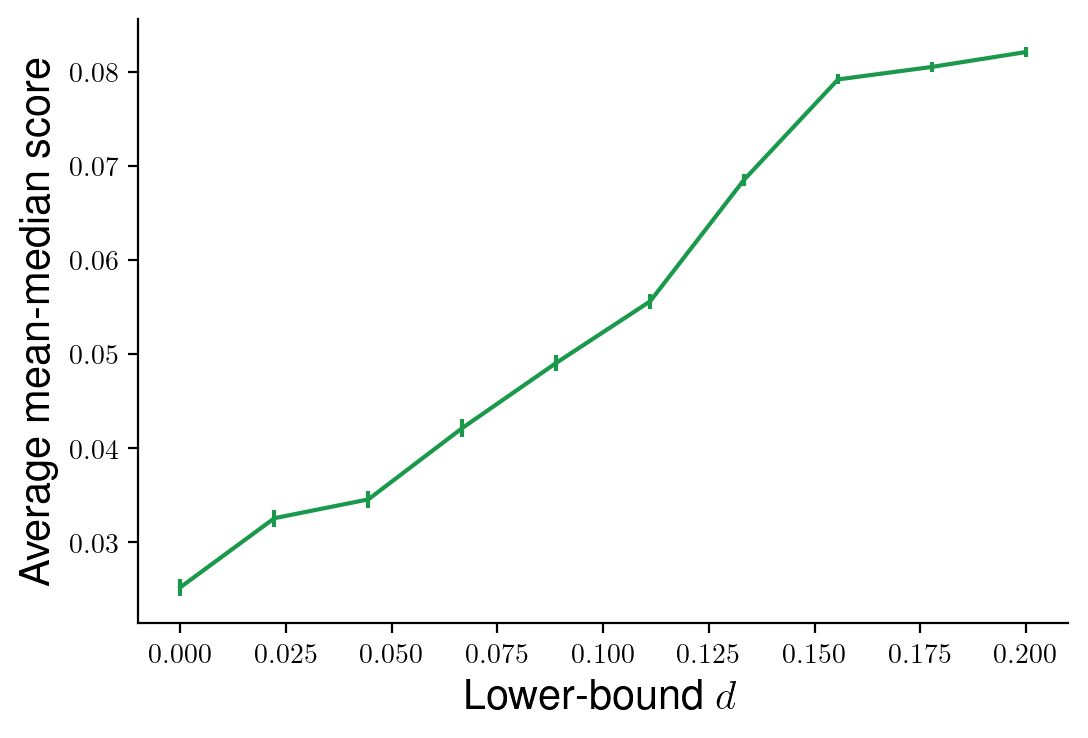

In [68]:
def plot_metrics_with_errorbars(delta_values, metric_values, se_metric_values,x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    font_name = 'Helvetica'
    font_size = 15
    ax.errorbar(deltas, avg_mean_medians, se_mean_medians,color=[0.1, 0.6, 0.3])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel(x_label, fontname=font_name, fontsize=font_size)
    ax.set_ylabel(y_label, fontname=font_name, fontsize=font_size)


plot_metrics_with_errorbars(deltas, avg_mean_medians, se_mean_medians,"Lower-bound $d$", "Average mean-median score")

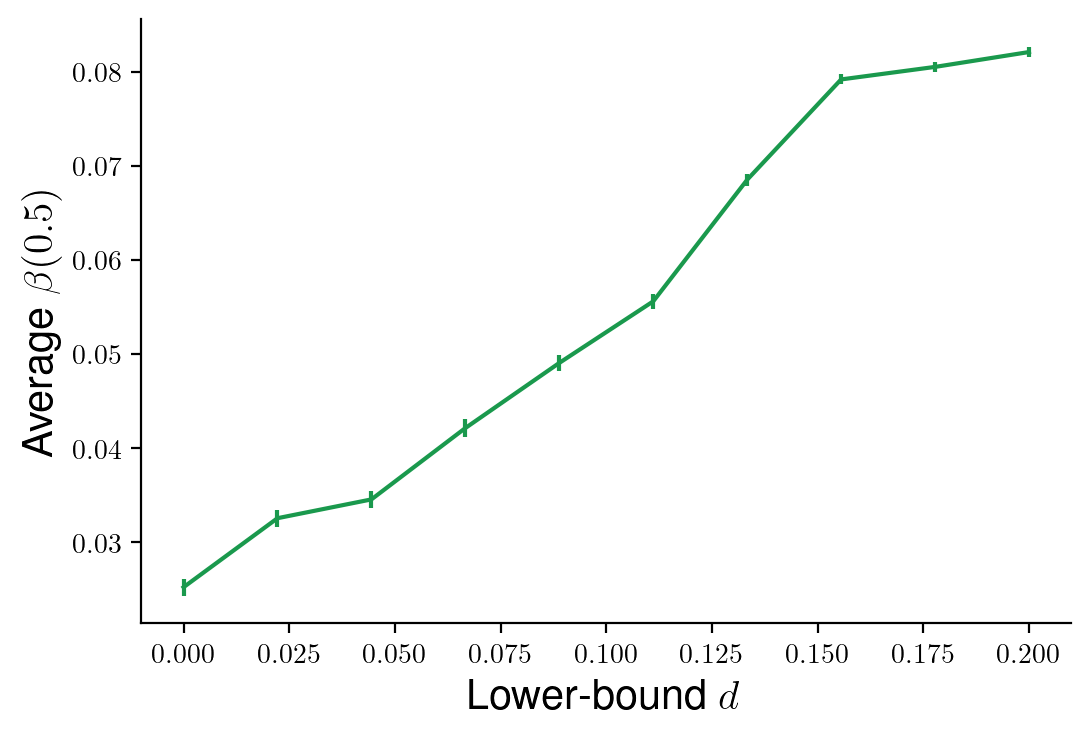

In [69]:
plot_metrics_with_errorbars(deltas, avg_beta_halves, se_beta_halves,"Lower-bound $d$", "Average $\\beta(0.5)$")

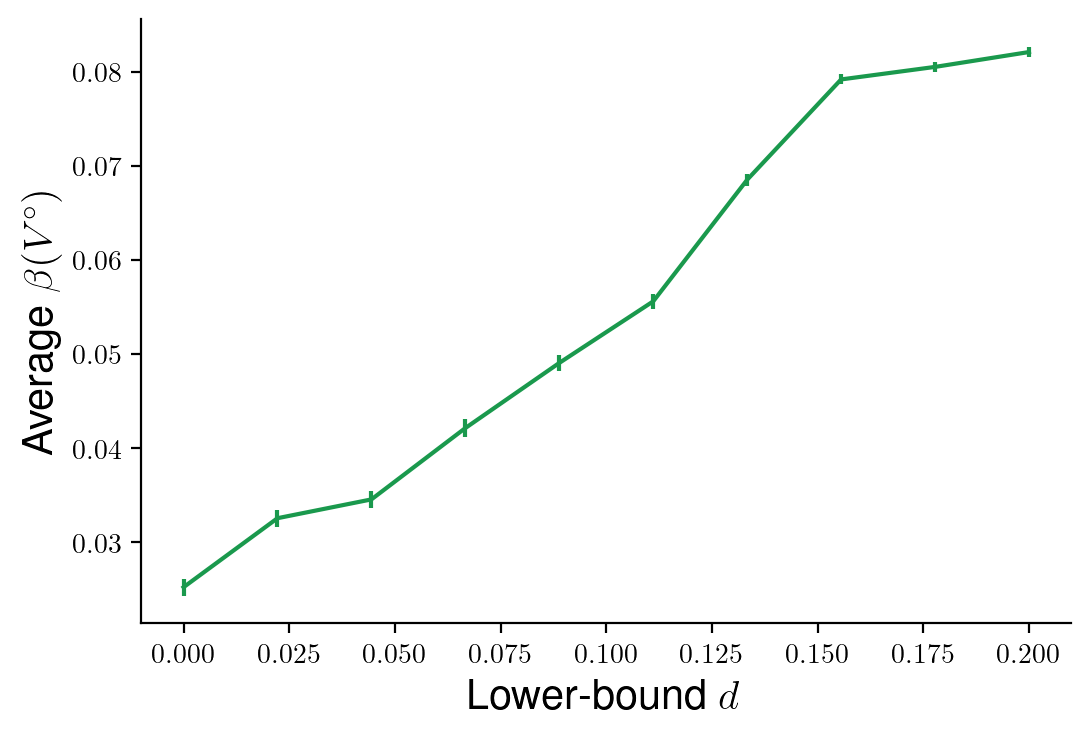

In [70]:
plot_metrics_with_errorbars(deltas, avg_beta_v0, se_beta_v0,"Lower-bound $d$", "Average $\\beta(V^\circ)$")

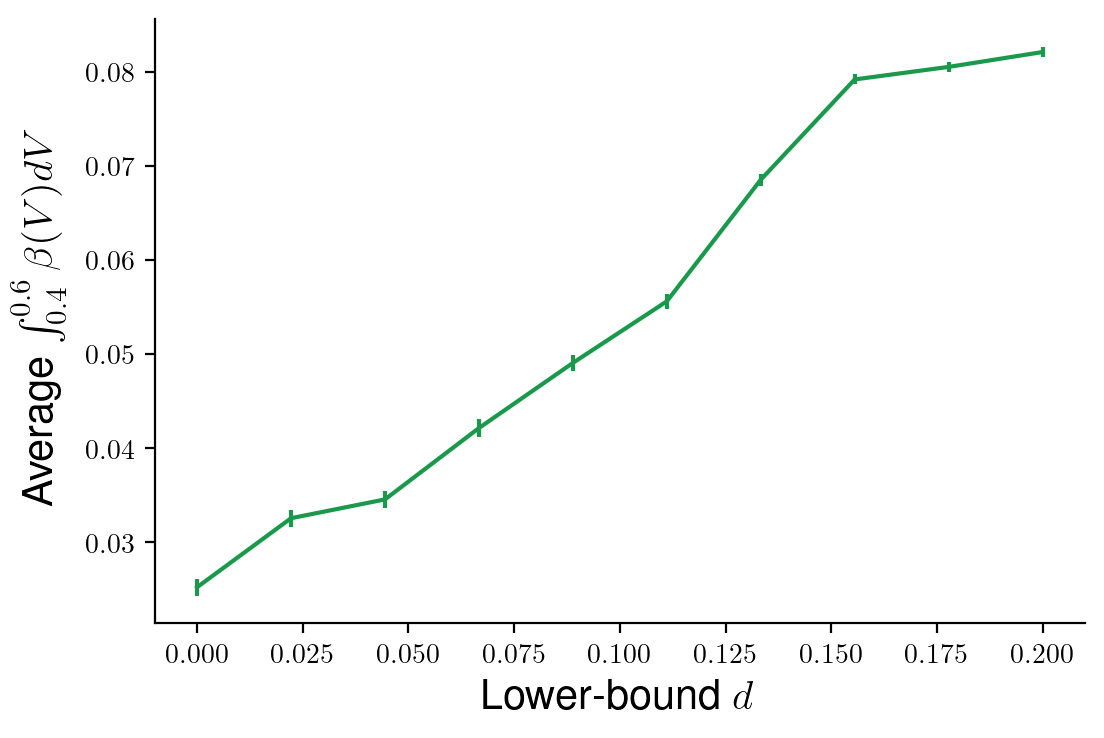

In [71]:
plot_metrics_with_errorbars(deltas, avg_beta_avg, se_beta_avg,"Lower-bound $d$", "Average $\int_{0.4} ^ {0.6} \\beta(V) dV$")